In [13]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

Pull in data.

In [14]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We see that if we look at the distribution of the BloodPressure column (after dropping 0), that the data looks to be relatively Normally distributed.

In [15]:
bp = data['BloodPressure']
bp = bp[bp != 0]

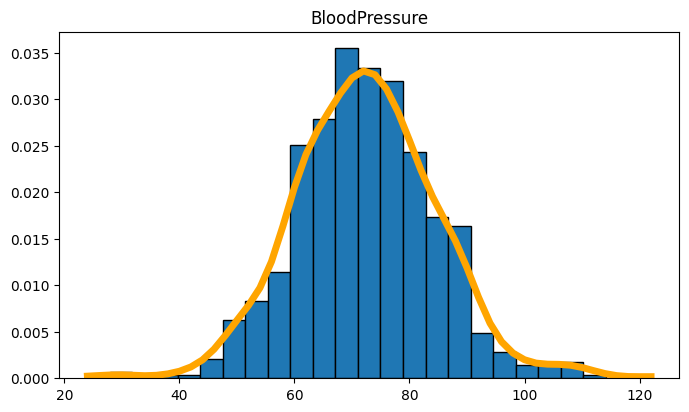

In [16]:
plt.figure(figsize=[8,4.5])
x = ss.gaussian_kde(bp)
lin = np.linspace(bp.min(), bp.max(), 50)
plt.hist(bp, bins=25, edgecolor='black', density=True)
plt.plot(lin, x(lin), color='orange', linewidth=5)
plt.title('BloodPressure')
plt.show()

### Bayesian Inference

We are going to use the pymc package to perform the Metropolis-Hastings Algorithm on the Blood Pressure variable. The Metropolis-Hastings Algorithm is a Markov Chain Monte Carlo (MCMC) method that is used in Bayesian Inference. In Bayesian Inference, one treats the moments (in our case the mean and standard deviation) of their sampled Random Variable as Random Variables themelves. In doing so, one can impart information about these moments in search of the populations's moments.

Bayes Theorem: $ P(\theta | X) = \frac {P(X | \theta) P(\theta)}{P(X)} $


Say, for example, that our dataset only sampled a small sample of the Pima Indian population. When looking at the blood pressure of samples of our dataset, we can see that our mean reading is 72.41. We are interested in finding the mean of the population's distribution and to do so, we will assume it is itself a Random Variable. In search of the population mean we are able to impart some bias into what we think that value is. We will assume that the population mean is also Normally distributed. Diastolic blood pressure is considered at a normal level if it's inbetween 60 and 80. For the sake of our analysis we will assume that the mode (and mean) of this distribution is 70 and that the standard deviation is 5. By the Normal distribution's empirical rule, this means that the true mean of the blood pressure of the population of Pima Indians has a 95% chance of being within the normal range. We are also interested in finding the standard deviation of the blood pressure of the population of Pima Indians. For the sake of simplicity, we will assume this variable is Lognormal and has a mode of 10 (where $\mu=2.5$ and $\sigma=0.44$), rather than the 12.38 indicated by the sample standard deviation. Since we are assuming that the distribution of blood pressure is Normal, by the Normal distribution's empirical rule, 68% of the Pima Indian population would have a diastolic blood pressure between 60 and 80, which is the range of normal readings.

In [17]:
print('              Blood Pressure Sample Mean: %.2f' % bp.mean())
print('Blood Pressure Sample Standard Deviation: %.2f' % bp.std())

              Blood Pressure Sample Mean: 72.41
Blood Pressure Sample Standard Deviation: 12.38


Lognormal Mode: 

$ mode = e^{\mu - \sigma^2} $

$ \ln(mode) = \mu - \sigma^2 $

In [18]:
with pm.Model():
    mu = pm.Normal('mu', mu=70, sigma=5)
    sigma = pm.Lognormal('sigma', mu=2.5, sigma=0.44)
    pmbp = pm.Normal('bp', mu=mu, sigma=sigma, observed=np.array(bp))
    step = pm.Metropolis()
    trace = pm.sample(draws=15000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 3 seconds.


In [19]:
stacked = az.extract(trace)

In [22]:
stacked.mu.values.mean()

72.37864579104486

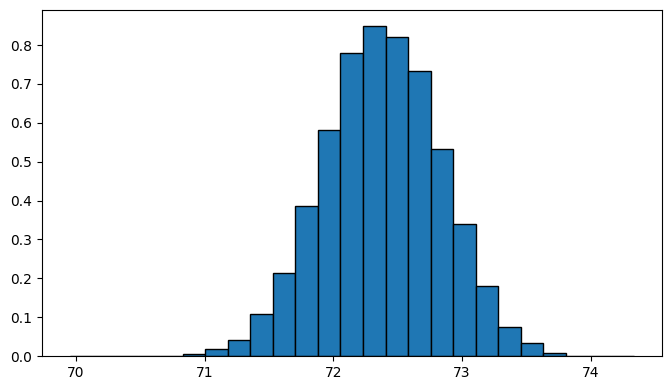

In [20]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.mu.values, edgecolor='black', density=True, bins=25)
plt.show()

In [25]:
stacked.sigma.values.mean() - stacked.sigma.values.std()**2

12.29618798431893

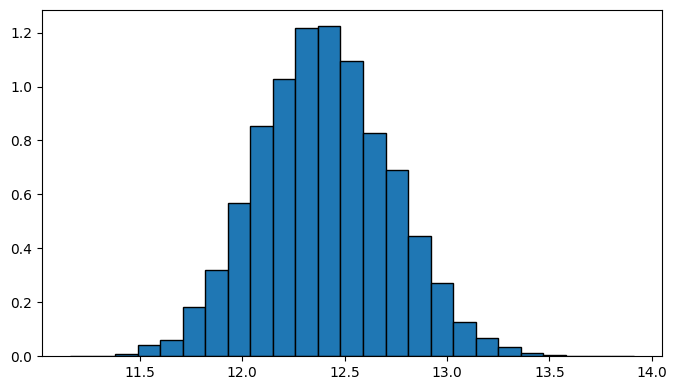

In [21]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.sigma.values, edgecolor='black', density=True, bins=25)
plt.show()

In [44]:
with pm.Model():
    mu = pm.Normal('mu', mu=0, sigma=4)
    sigma = pm.Lognormal('sigma', mu=2.5, sigma=10)
    pmbp = pm.Normal('bp', mu=mu, sigma=sigma, observed=np.array(bp)[:20])
    step = pm.Metropolis()
    trace = pm.sample(draws=15000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 3 seconds.


In [45]:
stacked = az.extract(trace)

In [46]:
stacked.mu.values.mean()

4.543050049685378

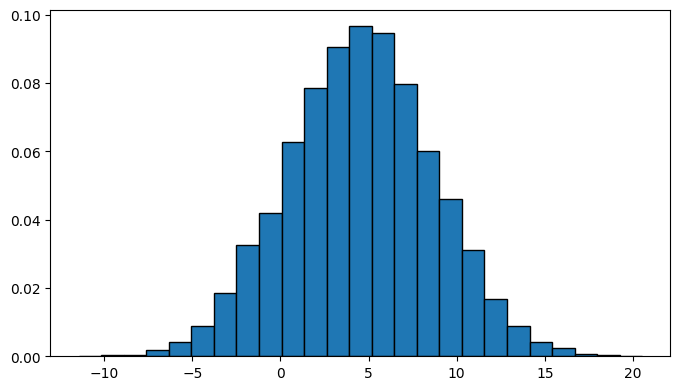

In [47]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.mu.values, edgecolor='black', density=True, bins=25)
plt.show()

In [48]:
stacked.sigma.values.mean() - stacked.sigma.values.std()**2

-84.41265669338485

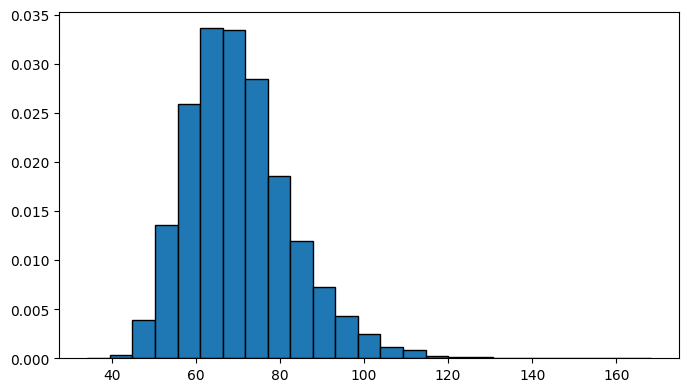

In [49]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.sigma.values, edgecolor='black', density=True, bins=25)
plt.show()